In [1]:
import cv2
import os 
import json 
import numpy as np
import pandas as pd
import ast
import pycocotools.mask as maskUtils
from matplotlib import pyplot as plt
import argparse

In [2]:
df = pd.read_csv('/Users/kerim/dev/BachelorThesis/results_eval/quant_eval_trials_nogt/eval_values.csv')
print(df.columns.tolist())

['pred_exists', 'image_file', 'gt_powerdrill', 'pred_powerdrill', 'mask_pixel_accuracy_powerdrill', 'bbox_iou_powerdrill', 'mask_iou_powerdrill', 'mask_dice_coefficient_powerdrill', 'result_img_file_powerdrill', 'gt_screwdriver', 'pred_screwdriver', 'mask_pixel_accuracy_screwdriver', 'bbox_iou_screwdriver', 'mask_iou_screwdriver', 'mask_dice_coefficient_screwdriver', 'result_img_file_screwdriver']


In [3]:
threshold_list = list(range(0, 100, 5))
threshold_list = [x/100 for x in threshold_list]
print(threshold_list)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [4]:
print(df['pred_powerdrill'].sum())

1986.0


In [29]:
# first do everything for bboxes
eval_dict = {}
for iou_threshold in threshold_list:
    #print("current threshold:" + str(iou_threshold))
    #calculate confusion matrix for powerdrill bbox

    powerdrill_TP_df = df[(df['gt_powerdrill'] == 1) & (df['pred_powerdrill'] == 1) & (df['bbox_iou_powerdrill'] >= iou_threshold)]
    powerdrill_FP_df = df[((df['gt_powerdrill'] == 1) & (df['pred_powerdrill'] == 1) & (df['bbox_iou_powerdrill'] < iou_threshold)) 
               | ((df['pred_powerdrill'] == 1) & (df['gt_powerdrill'] == 0))]
    #leave out TN for now
    powerdrill_FN_df = df[((df['gt_powerdrill'] == 1) & (df['pred_powerdrill'] == 0)) 
               | ((df['gt_powerdrill'] == 1) & (df['pred_powerdrill'] == 1) & (df['bbox_iou_powerdrill'] < iou_threshold))]
    
    screwdriver_TP_df = df[(df['gt_screwdriver'] == 1) & (df['pred_screwdriver'] == 1) & (df['bbox_iou_screwdriver'] >= iou_threshold)]
    screwdriver_FP_df = df[((df['gt_screwdriver'] == 1) & (df['pred_screwdriver'] == 1) & (df['bbox_iou_screwdriver'] < iou_threshold)) 
               | ((df['pred_screwdriver'] == 1) & (df['gt_screwdriver'] == 0))]
    screwdriver_FN_df = df[((df['gt_screwdriver'] == 1) & (df['pred_screwdriver'] == 0))
               | ((df['gt_screwdriver'] == 1) & (df['pred_screwdriver'] == 1) & (df['bbox_iou_screwdriver'] < iou_threshold))]
    
    eval_dict[iou_threshold] = {}

    eval_dict[iou_threshold]['powerdrill'] = {}
    eval_dict[iou_threshold]['powerdrill']['TP'] = len(powerdrill_TP_df)
    eval_dict[iou_threshold]['powerdrill']['FP'] = len(powerdrill_FP_df)
    eval_dict[iou_threshold]['powerdrill']['FN'] = len(powerdrill_FN_df)
    eval_dict[iou_threshold]['powerdrill']['precision'] = len(powerdrill_TP_df) / (len(powerdrill_TP_df) + len(powerdrill_FP_df))
    eval_dict[iou_threshold]['powerdrill']['recall'] = len(powerdrill_TP_df) / (len(powerdrill_TP_df) + len(powerdrill_FN_df))

    eval_dict[iou_threshold]['screwdriver'] = {}
    eval_dict[iou_threshold]['screwdriver']['TP'] = len(screwdriver_TP_df)
    eval_dict[iou_threshold]['screwdriver']['FP'] = len(screwdriver_FP_df)
    eval_dict[iou_threshold]['screwdriver']['FN'] = len(screwdriver_FN_df)
    eval_dict[iou_threshold]['screwdriver']['precision'] = len(screwdriver_TP_df) / (len(screwdriver_TP_df) + len(screwdriver_FP_df))
    eval_dict[iou_threshold]['screwdriver']['recall'] = len(screwdriver_TP_df) / (len(screwdriver_TP_df) + len(screwdriver_FN_df))
    
    eval_dict[iou_threshold]['total'] = {}
    eval_dict[iou_threshold]['total']['precision'] = (eval_dict[iou_threshold]['screwdriver']['precision'] + eval_dict[iou_threshold]['powerdrill']['precision']) / 2
    eval_dict[iou_threshold]['total']['recall'] = (eval_dict[iou_threshold]['screwdriver']['recall'] + eval_dict[iou_threshold]['powerdrill']['recall']) / 2
    print(f"Threshold: {iou_threshold:.2f} | Recall: {round(eval_dict[iou_threshold]['total']['recall'], 2):.2f} | Precision: {round(eval_dict[iou_threshold]['total']['precision'], 2):.2f} "
          f"| TP: {len(powerdrill_TP_df) + len(screwdriver_TP_df):4} | FN: {len(powerdrill_FN_df) + len(screwdriver_FN_df):4} | FP: {len(powerdrill_FP_df) + len(screwdriver_FP_df):4}")



                                                                      

Threshold: 0.00 | Recall: 0.87 | Precision: 1.00 | TP: 2806 | FN:  324 | FP:    0
Threshold: 0.05 | Recall: 0.59 | Precision: 0.68 | TP: 1884 | FN: 1246 | FP:  922
Threshold: 0.10 | Recall: 0.58 | Precision: 0.66 | TP: 1826 | FN: 1304 | FP:  980
Threshold: 0.15 | Recall: 0.55 | Precision: 0.64 | TP: 1745 | FN: 1385 | FP: 1061
Threshold: 0.20 | Recall: 0.53 | Precision: 0.61 | TP: 1673 | FN: 1457 | FP: 1133
Threshold: 0.25 | Recall: 0.51 | Precision: 0.59 | TP: 1600 | FN: 1530 | FP: 1206
Threshold: 0.30 | Recall: 0.48 | Precision: 0.56 | TP: 1523 | FN: 1607 | FP: 1283
Threshold: 0.35 | Recall: 0.45 | Precision: 0.52 | TP: 1426 | FN: 1704 | FP: 1380
Threshold: 0.40 | Recall: 0.42 | Precision: 0.49 | TP: 1325 | FN: 1805 | FP: 1481
Threshold: 0.45 | Recall: 0.38 | Precision: 0.44 | TP: 1207 | FN: 1923 | FP: 1599
Threshold: 0.50 | Recall: 0.35 | Precision: 0.41 | TP: 1103 | FN: 2027 | FP: 1703
Threshold: 0.55 | Recall: 0.32 | Precision: 0.37 | TP: 1003 | FN: 2127 | FP: 1803
Threshold: 0.60 

In [19]:
precision_list = []
recall_list = []
for iou_threshold in eval_dict:
    recall_list.append((eval_dict[iou_threshold]['screwdriver']['recall'] + eval_dict[iou_threshold]['powerdrill']['recall'])/2)
    precision_list.append((eval_dict[iou_threshold]['powerdrill']['precision'] + eval_dict[iou_threshold]['screwdriver']['precision'])/2)
print(recall_list)
print(precision_list)  

[0.8710771722845663, 0.5933950652403479, 0.5766169934350296, 0.5523819237357008, 0.5295449110493453, 0.5069657699212139, 0.482690920932186, 0.4509292395818734, 0.42044697120025676, 0.3841835231406767, 0.3512518218683407, 0.31704070762730874, 0.2782880473873101, 0.23159248060412713, 0.1824474809302248, 0.12958427404415224, 0.0767807360926284, 0.03360586772276056, 0.005493473652464997, 0.0007139457401237506]
[1.0, 0.683746591997642, 0.6648484513546041, 0.6372958268857614, 0.6109350821604893, 0.5850385626212757, 0.5570610124530249, 0.5201102841844129, 0.4853744504212414, 0.44385270061159826, 0.40585562351091786, 0.365643651904797, 0.3204357330582369, 0.26596357428831086, 0.2082301721808759, 0.14742465551543732, 0.08725652739911086, 0.038327438410335764, 0.006002996585857097, 0.0007552870090634441]


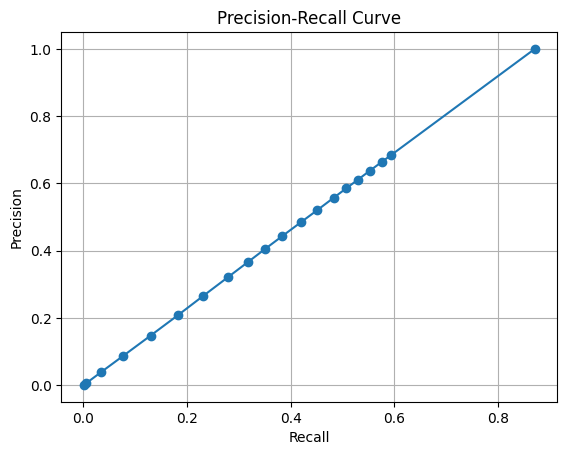

In [33]:
#fig, ax = plt.subplots()
plt.plot(recall_list, precision_list,marker='o', linestyle='-')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()